In [1]:
import sys
sys.path.append("./attack_flow_extension")
sys.path.append("./stix_probability")
sys.path.append("./")
import main
import attack_flow_extension.flow as flow
from stix_probability import weights
from dataclasses import dataclass
from typing import Dict, List
from mitreattack.stix20 import MitreAttackData
from pprint import pprint
import networkx as nx
import stix2
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.base import DAG
import numpy as np
from pgmpy import inference


d:\Development\ATTACK-RISK\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
flow_bundle = main.read_flow_file("Cobalt Kitty Campaign.json")
flows = flow.get_flows_from_stix_bundle(flow_bundle)
my_flow = flows[0]
attack_data = MitreAttackData('enterprise-attack.json')
probabilities = weights.ProbabilityDatabase(attack_data)
DG = nx.DiGraph()


In [3]:
for technique in attack_data.get_techniques():
    #print(list(technique.keys()))
    #print(technique['external_references'])
    pass
print(len(attack_data.get_techniques()))
for campaign in attack_data.get_campaigns():
    #print(list(campaign.keys()))
    pass
technique_by_group = attack_data.get_all_techniques_used_by_all_groups()

all_techniques = []
for group in technique_by_group:
    #print(group)
    for technique in technique_by_group[group]:
        #print(technique['object'].id)
        #print(type(technique['object']))
        all_techniques.append(technique['object'].id)
        pass
technique_by_campaign = attack_data.get_all_techniques_used_by_all_campaigns()
for campaign in technique_by_campaign:
    for technique in technique_by_campaign[campaign]:
        all_techniques.append(technique['object'].id)
        pass
len(list(set(all_techniques)))



780


444

In [4]:


#TODO breadth fitrst search to turn attack flow into nx graph
#then for every node just look up the probability and make the CPD

#breadth first search to turn attack flow into
#networkx graph
def bfs_attack_flow(attack_flow: flow.AttackFlow, flow_bundle: stix2.Bundle ) -> None | nx.DiGraph:
    G = nx.DiGraph()
    queue = []
    for starting_node in attack_flow.get_starting_points():
        backing_obj =flow.get_single_flow_object_by_id(starting_node, flow_bundle)
        G.add_node(starting_node, object=backing_obj)
        queue.append(starting_node)
    while queue:
        node = queue.pop(0)
        list_of_objs = flow_bundle.get_obj(node)
        if len(list_of_objs) != 1:
            print("Error: multiple objects with the same id")
            return None
        node_obj = list_of_objs[0]
        if 'effect_refs' not in node_obj:
            continue
        for child in node_obj['effect_refs']:
            if child not in queue:
                backing_obj = flow.get_single_flow_object_by_id(child, flow_bundle)
                G.add_node(child, object=backing_obj)
                queue.append(child)
            G.add_edge(node, child)
    return G

graph = bfs_attack_flow(my_flow, flow_bundle)

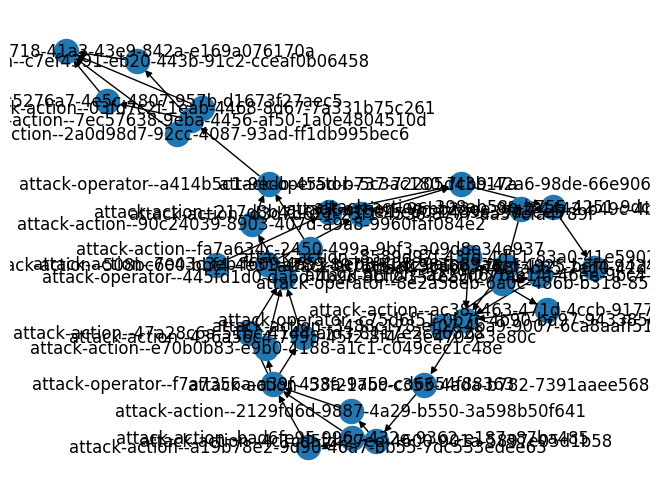

In [5]:
nx.draw(graph, with_labels=True)

In [6]:
print(len(probabilities.probability_mapping.keys()))

224


In [7]:
model = BayesianNetwork(graph)
for node, node_data in model.nodes(data=True):
    parents = list(model.predecessors(node))
    children = list(model.successors(node))
    flow_obj = node_data['object']
    if not parents:
        #isolated node
        if flow_obj.type == 'attack-action':
            #why do you just have the one node? this is a lot of work for just 1 node.
            relevant_attack_pattern = flow_obj.get_attack_pattern_id()
            probability = probabilities.get_probability_for_technique(relevant_attack_pattern)
            cpd = TabularCPD(variable=node, variable_card=2, values=[[probability], [1-probability]])
            model.add_cpds(cpd)
        elif flow_obj.type == 'attack-operator':
            #what is going on here? you have a lone attack operator not connected to anything. What does this mean? rethink your life
            cpd = TabularCPD(variable=node, variable_card=2, values=[[0.5], [0.5]])
        elif flow_obj.type == 'attack-condition':
            #what is going on here? you have a lone attack condition not connected to anything. What does this mean? rethink your life
            cpd = TabularCPD(variable=node, variable_card=2, values=[[0.5], [0.5]])
        else:
            raise ValueError("Unknown node type")
    elif parents:
        if flow_obj.type == 'attack-action':
            evidence_card = []
            probability = probabilities.get_probability_for_technique(relevant_attack_pattern)
            vals = np.zeros((2, 2**len(parents)))
            #top row is probability, bottom row is anti-probablity
            vals[0, :] = probability
            vals[1, :] = 1-probability
            evidence_card = [2] * len(parents)
            relevant_attack_pattern = flow_obj.get_attack_pattern_id()
            cpd = TabularCPD(variable=node, variable_card=2, values=vals, evidence=parents, evidence_card=evidence_card)
            model.add_cpds(cpd)
        elif flow_obj.type == 'attack-operator':
            vals = np.zeros((2, 2**len(parents)))
            #top row is probability, bottom row is anti-probablity
            vals[0, :] = probability
            vals[1, :] = 1-probability
            evidence_card = [2] * len(parents)
            if flow_obj.is_and():
                 # For AND, True only if all parents are True
                vals[0, :-1] = 1  # False for all combinations except last
                vals[0, -1] = 0   # False when all parents are True
                vals[1, :-1] = 0  # True only for last combination
                vals[1, -1] = 1   # True when all parents are True
            elif flow_obj.is_or():
                # For OR, True if any parent is True
                vals[0, 0] = 1    # False only when all parents are False
                vals[0, 1:] = 0   # False for all other combinations
                vals[1, 0] = 0    # True for all combinations except first
                vals[1, 1:] = 1   # True if any parent is True
            else:
                raise ValueError("Unknown operator type")
            cpd = TabularCPD(variable=node, variable_card=2, values=vals, evidence=parents, evidence_card=evidence_card)
            model.add_cpds(cpd)
        elif flow_obj.type == 'attack-condition':
            #the way the model is setup, the attack condition stuff doesn't really make sense. Placeholder it as a uniform binary thing
            cpd = TabularCPD(variable=node, variable_card=2, values=[[0.5], [0.5]])
        else :
            raise ValueError("Unknown node type")
   # print(parents)

model.check_model()


True

In [18]:

from pgmpy.readwrite import NETWriter
#from pgmpy.readwrite import XMLBIFWriter
#from pgmpy.readwrite import BIFWriter

#writer = BIFWriter(model= model)
#writer = XMLBIFWriter(model= model, prettyprint=True)
writer = NETWriter(model= model)
raw_hugin_file = str(writer)
raw_hugin_file = raw_hugin_file.replace("{", "\n{")

with open ("model.net", "w") as f:
    f.write(raw_hugin_file)
    f.close()
print(raw_hugin_file)

net {
}
node attack-action--03fd7c2f-1eab-4468-8d67-7a331b75c261{
    states = ("0"  "1");
    object = {"type": "attack-action", "spec_version": "2.1", "id": "attack-action--03fd7c2f-1eab-4468-8d67-7a331b75c261", "created": "2024-06-30T17:51:04.381Z", "modified": "2024-06-30T17:51:04.381Z", "name": "SMB/Windows Admin Shares", "tactic_id": "TA0008", "tactic_ref": "x-mitre-tactic--7141578b-e50b-4dcc-bfa4-08a8dd689e9e", "technique_id": "T1021.002", "technique_ref": "attack-pattern--4f9ca633-15c5-463c-9724-bdcd54fde541", "description": "Net.exe was used to perform lateral movement via Windows Admin Shares", "asset_refs": ["attack-asset--1eccea60-8db3-4ac0-9db2-d4eef1c3b484"], "effect_refs": ["attack-operator--65620718-41a3-43e9-842a-e169a076170a"], "extensions": {"extension-definition--fb9c968a-745b-4ade-9b25-c324172197f4": {"extension_type": "new-sdo"}}};
    weight = None;
}
node attack-action--2129fd6d-9887-4a29-b550-3a598b50f641{
    states = ("0"  "1");
    object = {"type": "attack-